In [1]:
import os
os.environ['THEANO_FLAGS'] = "device=cpu"

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import theano as th
import theano.tensor as T
import pymc3 as pm
import pickle
import csv
from statistics import median
from mpl_toolkits.mplot3d import axes3d

th.config.compute_test_value = 'ignore'

In [2]:
# Get the data
boxes = ['MultiJet', 'DiJet', 'LeptonMultiJet', 'LeptonJet']
sideband_x = {'MultiJet':650, 'DiJet':650, 'LeptonMultiJet':550, 'LeptonJet':550}
sideband_y = {'MultiJet':0.3, 'DiJet':0.3, 'LeptonMultiJet':0.2, 'LeptonJet':0.2}
btag_max = {'MultiJet':3, 'DiJet':2, 'LeptonMultiJet':3, 'LeptonJet':2}
data = { box:pd.read_csv("data/RazorFitInstance_Razor2016_MoriondRereco_{}.csv".format(box), index_col='NBtags')
           for box in boxes }
sideband_data = { box:data[box][ (data[box]['MR'] < sideband_x[box]) | (data[box]['Rsq'] < sideband_y[box]) ]
                    for box in boxes}

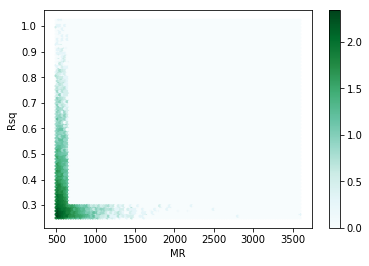

In [3]:
# Check the data
ax = sideband_data['MultiJet'].plot(kind='hexbin', x='MR', y='Rsq', bins='log', sharex=False);
plt.show()

In [4]:
# The analytical integral of the razor pdf (needed as part of the likelihood) requires the 
# upper incomplete gamma function, which is not included by default in Theano.
# We implement it here as a simple wrapper around the scipy implementation of the incomplete gamma.

class MyOp(th.Op):
    __props__ = ()
    
    def make_node(self, *inputs):
        inputs = [T.as_tensor_variable(inp) for inp in inputs]
        output = inputs[0].type()
        return th.Apply(self, inputs, [output])

class UpperIncGamma(MyOp):
    """Upper incomplete gamma function"""
    epsilon = 1e-6

    def perform(self, node, inputs, output_storage):
        a = inputs[0]
        x = inputs[1]
        z = output_storage[0]
        z[0] = np.array(sp.special.gamma(a) * sp.special.gammaincc(a, x))
      
upper_inc_gamma = UpperIncGamma()

In [5]:
class Sideband(object):
    """Class storing razor sideband geometry info."""
    def __init__(self, MRMin=500, MRMax=4000, RsqMin=0.25, RsqMax=1.5, 
                MRSidebandMax=650, RsqSidebandMax=0.30):
        self.MRMin = T.as_tensor_variable(MRMin)
        self.MRMax = T.as_tensor_variable(MRMax)
        self.RsqMin = T.as_tensor_variable(RsqMin)
        self.RsqMax = T.as_tensor_variable(RsqMax)
        self.MRSidebandMax = T.as_tensor_variable(MRSidebandMax)
        self.RsqSidebandMax = T.as_tensor_variable(RsqSidebandMax)
        
        # as floats
        self.MRMin_ = MRMin
        self.MRMax_ = MRMax
        self.RsqMin_ = RsqMin
        self.RsqMax_ = RsqMax
        self.MRSidebandMax_ = MRSidebandMax
        self.RsqSidebandMax_ = RsqSidebandMax
        
    def in_sideband(self, MR, Rsq):
        not_in = ( (MR < self.MRMin) + (MR > self.MRMax) + (Rsq < self.RsqMin) + (Rsq > self.RsqMax) 
                  + ((MR > self.MRSidebandMax)*(Rsq > self.RsqSidebandMax)) )
        return not_in < 1
        
hadronic_sideband = Sideband(500, 4000, 0.25, 1.5, 650, 0.30)
leptonic_sideband = Sideband(400, 4000, 0.15, 1.5, 550, 0.20)

hadronic_mr_sideband = Sideband(500, 650, 0.25, 1.5, 650, 1.5)
hadronic_rsq_sideband = Sideband(500, 4000, 0.25, 0.30, 4000, 0.30)

leptonic_mr_sideband = Sideband(400, 550, 0.15, 1.5, 550, 1.5)
leptonic_rsq_sideband = Sideband(400, 4000, 0.15, 0.20, 4000, 0.20)

In [6]:
def razor_p(MR, Rsq, P, n, A, B, MRMin, RsqMin):
    """Computes razor probability density (numpy version)."""
    term1 = (P+1) * np.power( (MR-MRMin+A)*(Rsq-RsqMin+B)/(A*B), 1./n )
    prob = (term1 - 1) * np.exp(-n * term1) 
    return prob

def gamma(a, x):
    return sp.special.gamma(a) * sp.special.gammaincc(a, x)
        
def gfun(MR, Rsq, P, n, A, B, MRMin, RsqMin):      
    b = (P+1)/np.power(A*B, 1./n)
    return n * np.power(b * n, -n) * gamma(n, b * n * np.power( (MR-MRMin+A) * (Rsq-RsqMin+B), 1./n ))

def razor_int(P, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sideband):
    return (  gfun(MRMin, RsqMin, P, n, A, B, sideband.MRMin_, sideband.RsqMin_) 
            - gfun(MRMin, RsqMax, P, n, A, B, sideband.MRMin_, sideband.RsqMin_) 
            - gfun(MRMax, RsqMin, P, n, A, B, sideband.MRMin_, sideband.RsqMin_) 
            + gfun(MRMax, RsqMax, P, n, A, B, sideband.MRMin_, sideband.RsqMin_))

def razor_norm(P, n, A, B, sideband):
    norm_MR_sideband = razor_int(P, n, A, B, sideband.MRMin_, sideband.MRSidebandMax_, 
                                          sideband.RsqMin_, sideband.RsqMax_, sideband)
    norm_Rsq_sideband = razor_int(P, n, A, B, sideband.MRSidebandMax_, sideband.MRMax_, 
                                          sideband.RsqMin_, sideband.RsqSidebandMax_, sideband)
    return norm_MR_sideband + norm_Rsq_sideband

def razor_p_sidebandnormalized(MR, Rsq, P, n, A, B, nevents, sideband=hadronic_sideband):
    """Returns probability normalized to the given number of events in the given sideband"""
    p = razor_p(MR, Rsq, P, n, A, B, sideband.MRMin_, sideband.RsqMin_)
    norm = razor_norm(P, n, A, B, sideband)
    return nevents*p/norm

In [7]:
# Create PyMC3 class for razor PDF
from pymc3.distributions import Continuous
from pymc3.distributions.dist_math import bound

class Razor(Continuous):
    def __init__(self, P, n, A, B, sideband, **kwargs):
        super(Razor, self).__init__(**kwargs)
        self.P = P
        self.n = n
        self.A = A
        self.B = B
        self.sideband = sideband
    
    def gamma(self, a, x):
        return upper_inc_gamma(a, x)
        
    def gfun(self, MR, Rsq):
        P = self.P
        n = self.n
        A = self.A
        B = self.B
        
        b = (P+1)/T.pow(A*B, 1./n)
        MRMin = self.sideband.MRMin
        RsqMin = self.sideband.RsqMin
        
        return n * T.pow(b * n, -n) * self.gamma(n, b * n * T.pow( (MR-MRMin+A) * (Rsq-RsqMin+B), 1./n ))
    
    def integral(self, MRMin, MRMax, RsqMin, RsqMax):
        return (self.gfun(MRMin, RsqMin) - self.gfun(MRMin, RsqMax) 
                - self.gfun(MRMax, RsqMin) + self.gfun(MRMax, RsqMax))
    
    def norm(self):
        norm_MR_sideband = self.integral( self.sideband.MRMin, self.sideband.MRSidebandMax, 
                                          self.sideband.RsqMin, self.sideband.RsqMax )
        norm_Rsq_sideband = self.integral( self.sideband.MRSidebandMax, self.sideband.MRMax, 
                                          self.sideband.RsqMin, self.sideband.RsqSidebandMax )
        return norm_MR_sideband + norm_Rsq_sideband

    def logp(self, values):
        MR = values[:,0]
        Rsq = values[:,1]
        P = self.P
        n = self.n
        A = self.A
        B = self.B
        MRMin = self.sideband.MRMin
        RsqMin = self.sideband.RsqMin
        
        term1 = (P+1) * T.pow( (MR-MRMin+A)*(Rsq-RsqMin+B)/(A*B), 1./n )
        logprob = (-n * term1) + T.log(term1 - 1)
        lognorm = T.log(self.norm())
        return bound(logprob - lognorm, A>0, B>0, P>0, n>0)

In [8]:
# To visualize fits in 3D

def compare_fit_and_data(trace, d, sideband):
    xmin = sideband.MRMin_
    xmax = sideband.MRSidebandMax_
    ymin = sideband.RsqMin_
    ymax = sideband.RsqSidebandMax_
    
    xstep = 10.
    ystep = 0.01
    nx = int((xmax-xmin)/xstep)
    ny = int((ymax-ymin)/ystep)
    gridx_ = np.arange(xmin, xmax+xstep, xstep)
    gridy_ = np.arange(ymin, ymax+ystep, ystep)
    gridx, gridy = np.meshgrid(gridx_, gridy_)

    # Data
    binstepx = (xmax-xmin)/10.
    binstepy = (ymax-ymin)/10.
    data_bins = (np.arange(xmin, xmax+binstepx, binstepx), np.arange(ymin, ymax+binstepy, binstepy)) 
    data_hist = np.log(np.histogram2d(d["MR"], d["Rsq"], bins=data_bins)[0]).T - np.log(binstepx*binstepy)
    data_binsx, data_binsy = np.meshgrid((data_bins[0][:-1]+data_bins[0][1:])/2., 
                                         (data_bins[1][:-1]+data_bins[1][1:])/2.)
    data_norm = len(d)

    # Fit 
    pdf_vals = np.zeros((nx, ny))
    pdf_vals = np.log(razor_p_sidebandnormalized(gridx, gridy, median(trace["P"]), median(trace["n"]), 
                                             median(trace["A"]), median(trace["B"]), data_norm, sideband=sideband))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(gridx, gridy, pdf_vals)
    ax.plot_surface(data_binsx, data_binsy, data_hist)
    ax.set_xlabel('MR (GeV)')
    ax.set_ylabel('Rsq (GeV)')
    ax.set_zlabel('log density')
    plt.show()
    
# Visualize fit residuals 
def vis_resids(trace, d, sideband):
    xmin = sideband.MRMin_
    xmax = min(2000, sideband.MRSidebandMax_)
    ymin = sideband.RsqMin_
    ymax = sideband.RsqSidebandMax_

    # Data
    nbinsx = 6.
    nbinsy = 6.
    if sideband.RsqSidebandMax_ > 1.:
        nbinsx = 6.
        nbinsy = 7.
    binstepx = (xmax-xmin)/nbinsx
    binstepy = (ymax-ymin)/nbinsy
    data_bins = [np.arange(xmin, xmax+binstepx, binstepx), np.arange(ymin, ymax+binstepy, binstepy)]
    if len(data_bins[1]) < nbinsy+1:
        data_bins[1].append(ymax)
    data_hist = np.histogram2d(d["MR"], d["Rsq"], bins=data_bins)[0]
    data_binsx, data_binsy = np.meshgrid((data_bins[0][:-1]+data_bins[0][1:])/2., 
                                         (data_bins[1][:-1]+data_bins[1][1:])/2., indexing='ij')
    data_norm = len(d[ (d['MR'] < xmax) & (d['Rsq'] < ymax) ])
    
    P = median(trace["P"])
    n = median(trace["n"])
    A = median(trace["A"])
    B = median(trace["B"])
    pdf_vals = np.zeros((len(data_bins[0])-1, len(data_bins[1])-1))
    fit_norm = razor_norm(P, n, A, B, sideband)
    for bx,mr_low in enumerate(data_bins[0][:-1]):
        for by,rsq_low in enumerate(data_bins[1][:-1]):
            mr_high = data_bins[0][bx+1]
            rsq_high = data_bins[1][by+1]
            integral = razor_int(P, n, A, B, mr_low, mr_high, rsq_low, rsq_high, sideband) * data_norm / fit_norm
            pdf_vals[bx,by] = integral

    resids = np.clip(data_hist / pdf_vals, 0., 3.)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(data_binsx, data_binsy, resids)
    ax.set_xlabel('MR (GeV)')
    ax.set_ylabel('Rsq')
    ax.set_zlabel('Data/Fit')
    if ax.get_xlim()[1] > 2000:
        ax.set_xlim(xmin, 2000)
    ax.set_zbound(0., 3.)
    plt.show()

In [9]:
# Get nsigma values in every sideband bin

bins_hadronic = ([500, 575, 650, 750, 900, 1200, 1600, 2500, 4000], [0.25,0.30,0.41,0.52,0.64,1.5])
bins_leptonic = ([400, 475, 550, 700, 900, 1200, 1600, 2500, 4000], [0.15,0.20,0.25,0.30,0.41,0.52,0.64,1.5])

def get_data_yield(d, bin_coords):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    return len(d[ (d['MR'] > mrmin) & (d['MR'] < mrmax) & (d['Rsq'] > rsqmin) & (d['Rsq'] < rsqmax) ])

def get_pred_yields(trace, bin_coords, sband, norm):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    yields = []
    for i in range(len(trace)):
        P = trace['P'][i]
        n = trace['n'][i]
        A = trace['A'][i]
        B = trace['B'][i]
        full_int = razor_norm(P, n, A, B, sband)
        yields.append( razor_int(P, n, A, B, mrmin, mrmax, rsqmin, rsqmax, sband)*norm/full_int )
    return np.array(yields)

def get_nsigma(obs, preds):
    central_pred = median(preds)
    total = float(len(preds))
    if obs > central_pred:
        cdf = 1 - len(preds[preds > obs])/total
    else:
        cdf = len(preds[preds < obs])/total
    print obs, central_pred, sp.stats.iqr(preds), cdf
    return sp.stats.norm.ppf(cdf)

def get_nsigmas(trace, d, box):
    bins = bins_hadronic
    sband = hadronic_sideband
    if 'Lepton' in box:
        bins = bins_leptonic
        sband = leptonic_sideband
    norm = len(d)
    nsigmas = {}
    for ix, mrlow in enumerate(bins[0][:-1]):
        mrhigh = bins[0][ix+1]
        # only consider bins in sideband (2 bins in MR, 1 in Rsq)
        if ix < 2:
            iymax = len(bins[1])-1
        else:
            iymax = 1
        for iy, rsqlow in enumerate(bins[1][:iymax]):
            rsqhigh = bins[1][iy+1]
            this_bin = (mrlow, mrhigh, rsqlow, rsqhigh)
            this_yield = get_data_yield(d, this_bin)
            this_preds = get_pred_yields(trace, this_bin, sband, norm)
            nsigmas[this_bin] = get_nsigma(this_yield, this_preds)
    return nsigmas

In [15]:
# Model setup and training

def build_model(data, nbtags, box='MultiJet',
               prior_slopes=[0.005, 0.04, 0.0001, .1],
               initial_vals=[5, 1, 300., 0.15],
               sideband=None):
    """Create PyMC3 model with razor pdf and observed data.
        prior_slopes: slopes for the exponential priors on P, n, A, B
        initial_vals: test values for parameters"""
    with pm.Model() as model:
        # PDF variables
        P = pm.Exponential("P", prior_slopes[0], testval=initial_vals[0])
        n = pm.Exponential("n", prior_slopes[1], testval=initial_vals[1])
        A = pm.Exponential("A", prior_slopes[2], testval=initial_vals[2])
        B = pm.Exponential("B", prior_slopes[3], testval=initial_vals[3])
            
        if sideband is not None:
            sband = sideband
        elif box in ['LeptonJet','LeptonMultiJet']:
            sband = leptonic_sideband
        else:
            sband = hadronic_sideband
            
        observed = data.ix[nbtags][['MR','Rsq']].values
        razor_pdf = Razor("razor_pdf", P=P, n=n, A=A, B=B, sideband=sband,
                          shape=len(observed), observed=observed)
    return model

def fit_model(model, samples=10000, burn_period=5000):
    """Fit the model and return
        samples from the posterior"""
    with model:
        step = pm.Slice()
        trace = pm.sample(samples, step=step)
        burned_trace = trace[burn_period:]
    return burned_trace
    
def visualize_trace(trace):
    varnames = ['P','n','A','B']
    # Visualize posteriors and MCMC traces
    pm.plots.traceplot(trace=trace, varnames=varnames);
    plt.show()
    # Plot the autocorrelation of the MCMC traces.
    # Long tails on this plot mean that the Markov chain is not sampling uniformly from the posterior.
    pm.plots.autocorrplot(trace=trace, varnames=varnames);
    plt.show()
    # Visualize the posteriors for the function parameters
    pm.plot_posterior(trace=trace, varnames=varnames);
    plt.show()
    
def fit_and_plot(data, nbtags, samples=10000, burn_period=5000, sideband=None, box='MultiJet'):
    """Build the model, fit it, and make diagnostic plots.
        Returns the MCMC trace."""
    model = build_model(data, nbtags, sideband=sideband, box=box)
    trace = fit_model(model, samples, burn_period)
    visualize_trace(trace)
    return trace

def save_traces(traces, fname):
    pickle.dump(traces, open(fname, "wb"))
    
def load_traces(fname):
    return pickle.load(open(fname, "rb"))

  0%|          | 1/10000 [00:00<2:35:42,  1.07it/s]

ValueError: zero-size array to reduction operation maximum which has no identity

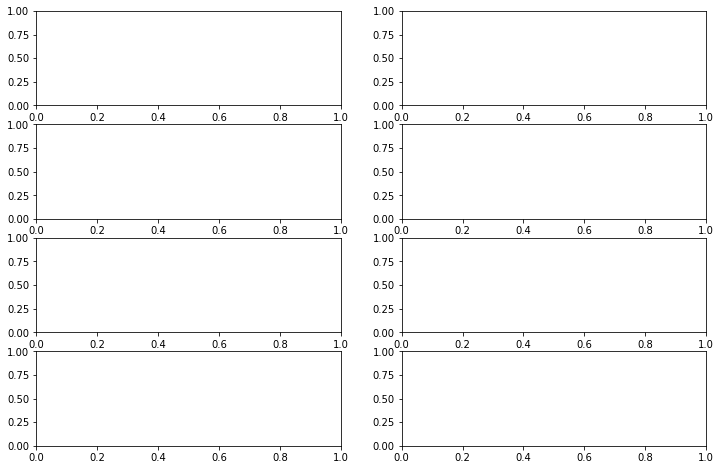

In [16]:
%matplotlib inline
trace = fit_and_plot(sideband_data['MultiJet'], 0, samples=10000, burn_period=0, box='MultiJet')

In [24]:
get_nsigmas(trace, sideband_data["MultiJet"].ix[0], 'MultiJet')

1584 1554.68275736 31.7438967133 0.8979
1635 1720.08574305 15.8348284253 0.0
675 676.904631647 12.0897501828 0.4114
309 299.661022171 8.56915642968 0.914
259 224.724204635 11.4710337903 1.0
1006 937.496991689 10.3871761652 1.0
984 1032.1727221 7.76217185326 0.0
390 402.968153674 8.11957928965 0.0179
199 177.002548828 5.31432349514 1.0
131 131.207569739 7.58938959419 0.4853
708 715.392553511 10.391981521 0.1612
504 507.762832424 12.9053441002 0.3411
297 307.808835482 12.6223648226 0.1267
78 73.087606349 5.33753217781 0.8924
15 14.6410931024 2.15061927779 0.5916
2 0.580819646241 0.215027442206 1.0


{(500, 575, 0.25, 0.3): 1.269676182917191,
 (500, 575, 0.3, 0.41): -inf,
 (500, 575, 0.41, 0.52): -0.22394512837374886,
 (500, 575, 0.52, 0.64): 1.3658055625722723,
 (500, 575, 0.64, 1.5): inf,
 (575, 650, 0.25, 0.3): inf,
 (575, 650, 0.3, 0.41): -inf,
 (575, 650, 0.41, 0.52): -2.0991917610581026,
 (575, 650, 0.52, 0.64): inf,
 (575, 650, 0.64, 1.5): -0.036855777768126173,
 (650, 750, 0.25, 0.3): -0.98953797412651534,
 (750, 900, 0.25, 0.3): -0.40946288333420755,
 (900, 1200, 0.25, 0.3): -1.1421299690087627,
 (1200, 1600, 0.25, 0.3): 1.239392979763009,
 (1600, 2500, 0.25, 0.3): 0.23166270562397495,
 (2500, 4000, 0.25, 0.3): inf}

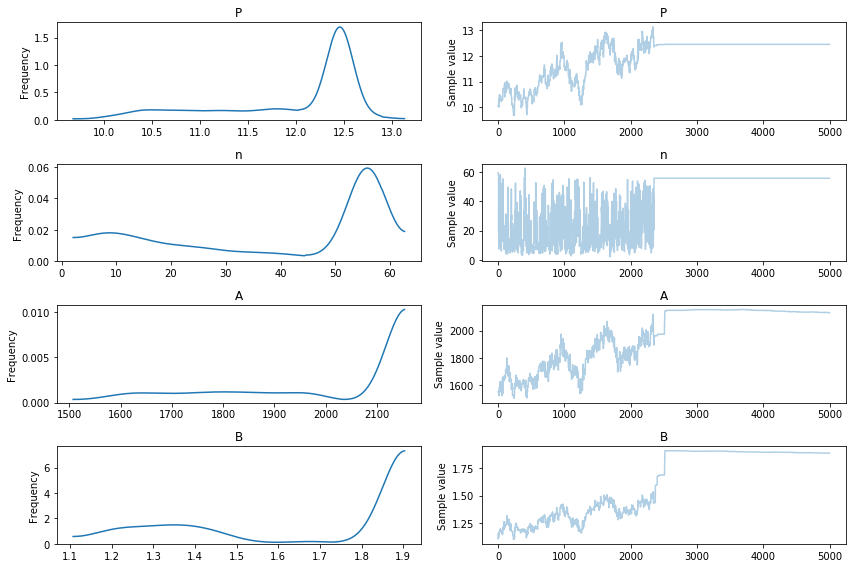

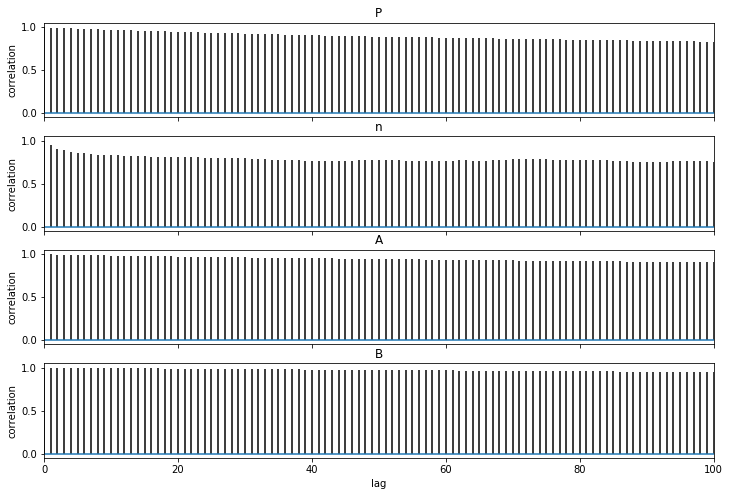

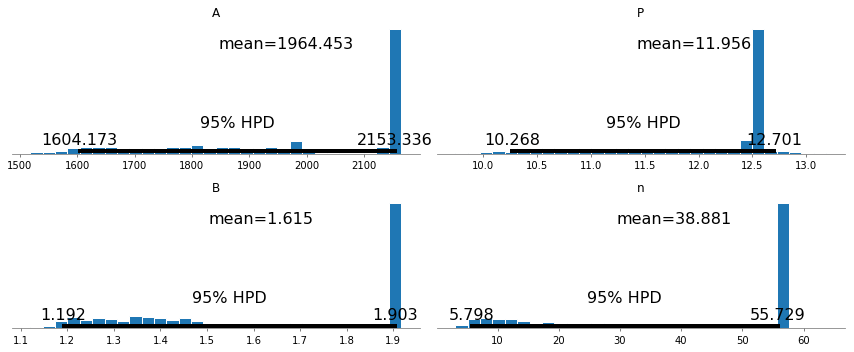

In [14]:
visualize_trace(trace[5000:])